In [2]:
ls ../data/

file-cache.csv            output_data/
found-science-articles/   science_articles.json.gz


In [38]:
import sys
sys.path.insert(0, '../../../google-research/reasoning-schema/make_label_hierarchy/')
import create_trees as c
import pandas as pd 
import datetime
import os 
import pandas as pd 
import warnings
import pyperclip
import json
import os 
from openai import OpenAI
import ast

# -----------------
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['OPENAI_API_KEY'] = open('/Users/spangher/.openai-bloomberg-project-key.txt').read().strip()
warnings.simplefilter(action='ignore')
client = OpenAI()


def simple_json_parse(j):
    try:
        return json.loads(j)
    except:
        try:
            return ast.literal_eval(j)
        except:
            return None


def prompt_openai(prompt, model='gpt-4o-mini'):
    completion = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return completion.choices[0].message.content


science_articles_df = pd.read_json('../data/science_articles.json.gz')

# Get Topic Hierarchy

In [47]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")
# sentences = science_articles_df.pipe(lambda df: df['headline'] + ' ' + df['summary']).tolist()
sentences = science_articles_df.pipe(lambda df: df['headline']).tolist()
embeddings = model.encode(sentences)

In [48]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=128, n_init="auto").fit(embeddings)

In [49]:
science_articles_df['kmeans_128_cluster_center'] = kmeans.labels_

In [53]:
NODE_PROMPT = """You are a helpful assistant. I will give you a list of news headlines and summaries. You will summarize them and 
return a single, specific topic label and a description in the following forward: "Label": Description. 
Please condense them into a single, specific label. Be precise and concise. Ignore labels that are too generic.
Please return just one 2-3 word label and one description.

Here are some examples of how I want my outputs:
<examples>
output:
"Space Industry": These articles cover missions planned either by government or private companies into space.

output:
"Heart Health": The step covers medical advances impacting cardiovascular systems.
</examples>

Now it's your turn. Here are the article headlines and summaries:
<articles>
{articles_and_summaries}
</articles>

output:
"""

In [59]:
from tqdm.auto import tqdm

In [62]:
cluster_summaries = {}
clusters = science_articles_df['kmeans_128_cluster_center'].drop_duplicates().tolist()
for cluster in tqdm(clusters):
    summs = (science_articles_df
     .loc[lambda df: df['kmeans_128_cluster_center'] == cluster]
     .apply(lambda x: 'Headline: ' + x['headline'] + ' Summary: ' + x['summary'], axis=1)
    )
    input_str = '\n'.join(summs.tolist())
    prompt = NODE_PROMPT.format(articles_and_summaries=input_str)
    summary = prompt_openai(prompt, model='gpt-4.1')
    cluster_summaries[cluster] = summary

  0%|          | 0/128 [00:00<?, ?it/s]

In [74]:
cluster_summaries_df = pd.Series(cluster_summaries).to_frame('label')
cluster_summaries_df = (
    cluster_summaries_df
        .reset_index().rename(columns={'index': 'node_id'}).sort_values('node_id')
        .reset_index(drop=True)
)

In [76]:
cluster_summaries_df.to_csv('../data/output_data/kmeans-initial-labels.csv')

In [77]:
cluster_summaries_df

,node_id,label
0,0,"""Nursing Home Staffing"": These articles focus ..."
1,1,"""Marine Animal Reproduction"": These stories hi..."
2,2,"""HIV & Drug Policy"": These articles discuss ch..."
3,3,"""Solar & Cosmic Phenomena"": These articles cov..."
4,4,"""Animal-Borne Bird Flu"": These articles discus..."
...,...,...
123,123,"""Pet Behavior"": These articles explore the com..."
124,124,"""Pandemic Response Setbacks"": These articles d..."
125,125,"""Food Safety Violations"": The articles detail ..."
126,126,"""Teen Mental Health"": These articles explore f..."


In [83]:
leaf_node_counts = science_articles_df['kmeans_128_cluster_center'].value_counts().to_dict()

In [84]:
kmeans_centers = kmeans.cluster_centers_

In [89]:
G, pruned_G, inner_node_label_dict = c.cluster_hierarchical_tree(
    kmeans_centers, cluster_summaries_df, leaf_node_counts, min_cluster_size=2
)

  0%|          | 0/19 [00:00<?, ?it/s]

In [96]:
pruned_G.nodes[128]

{'subtree_size': 1100, 'label_to_plot': '"RFK Jr. Vaccine Debate Influence"'}

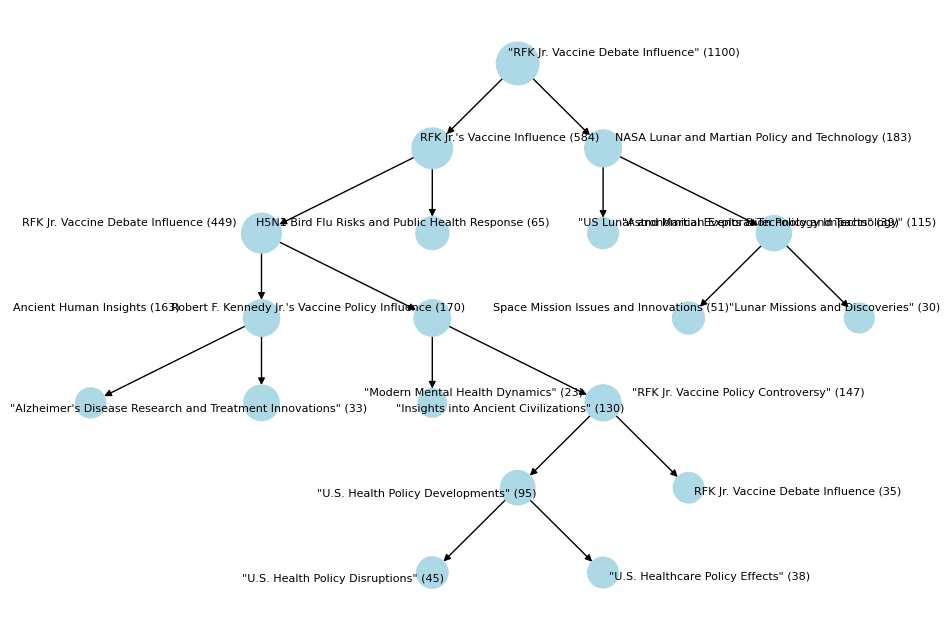

In [93]:
c.plot_graph(pruned_G, with_sizes=True, font_size=8, node_max_size=50, node_min_size=1, node_size_log_base=1.1)

# Agglomerative Clustering

In [126]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

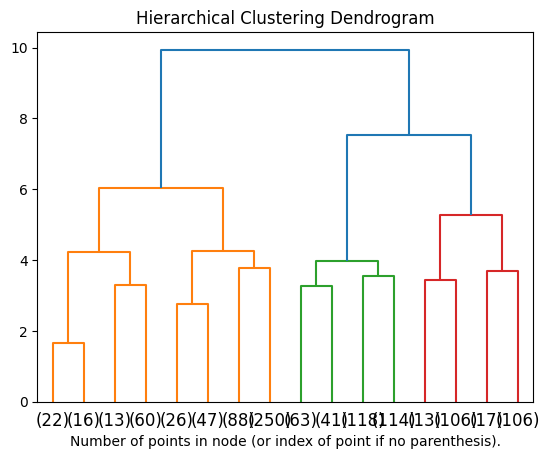

In [127]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(embeddings)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [132]:
def convert_agglomerative_model_to_networkx(model, n_samples):
    # children_[i] = (left_child, right_child) that were merged at step i
    children = model.children_

    # 2) Build the directed graph
    G = nx.DiGraph()

    # a) Add leaf nodes
    for i in range(n_samples):
        G.add_node(i, indices=[i], size=1)

    # b) Add internal nodes and edges
    #    New node IDs run from n_samples to n_samples + len(children) - 1
    for step, (left, right) in enumerate(children):
        parent = n_samples + step

        # gather data-point indices under this cluster
        left_indices  = G.nodes[left]['indices']
        right_indices = G.nodes[right]['indices']
        all_indices   = left_indices + right_indices

        # add the new cluster node
        G.add_node(parent,
                   indices=all_indices,
                   size=len(all_indices))

        # connect parent -> its two children
        G.add_edge(parent, left)
        G.add_edge(parent, right)

    # The final merge is the true root
    root = n_samples + children.shape[0] - 1

    return G, root

In [139]:
G, root = convert_agglomerative_model_to_networkx(model, n_samples=embeddings.shape[0])

In [146]:
import sys
sys.path.insert(0, '../clustering_files/')
from importlib import reload

In [387]:
import tree_helper_functions as h
import tree_functions as t
import numpy as np 
reload(t)
reload(h)

<module 'tree_helper_functions' from '/Users/spangher/Projects/other/nytimes-project/notebooks/../clustering_files/tree_helper_functions.py'>

In [148]:
linkage_matrix, dendrogram_dict, G_2, cluster_labels = a.hierarchical_clustering_to_networkx(embeddings)

In [245]:
proper_sparse_G = t.create_proper_sparse_tree(embeddings, n_samples=len(embeddings), distance_thresholds=[10, 7, 5, 3])

In [248]:
leaves = h.get_all_leaf_nodes(proper_sparse_G)
node_labels = (
    science_articles_df
         .reset_index()
         .assign(label=lambda df: df['headline'] + '. ' + df['summary'] + '. ' + df['bodyText'].apply(lambda x: x[:500] + '...'))
         ['label'].to_dict()
)

nx.set_node_attributes(proper_sparse_G, node_labels, 'label')

In [256]:
proper_sparse_G.nodes[0]

{'type': 'sample',
 'level': 'leaf',
 'label': 'A Cautionary Tale of 408 Tentacles. One pet octopus suddenly became more than four dozen. They went viral. Then it all went south.. Pet Theory\n\nA Cautionary Tale of 408 Tentacles\n\n\nOnce upon a time, there was an octopus-besotted boy named Cal who lived in the landlocked state of Oklahoma. One day, a special package appeared at his house: a small pet octopus, with bright blue eyespots on its head, that Cal named Terrance.\n\nTerrance turned out to be female — and pregnant. One octopus turned into 51, eight tentacles into 408. The boy’s father, Dr. Cameron Clifford, worked day and night to keep the octopuses alive.\n\nLast spring,...',
 'subtree_size': 1}

In [373]:
G, pruned_G, inner_node_summary_dict, inner_node_label_dict = h.label_hierarchical_tree_based_on_node_labels(proper_sparse_G)

  0%|          | 0/29 [00:00<?, ?it/s]

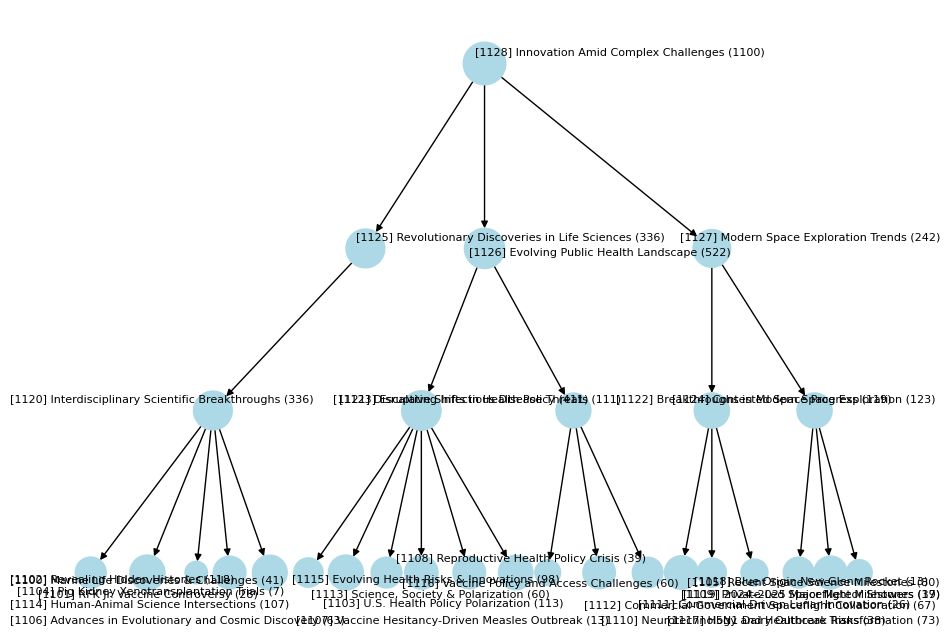

In [374]:
c.plot_graph(pruned_G, with_sizes=True, with_node_id=True, with_labels=True, font_size=8, node_max_size=50, node_min_size=1, node_size_log_base=1.1)

In [375]:
print(pruned_G.nodes[1120]['summary'])

Recent scientific research showcases a wave of discoveries spanning evolution, artificial intelligence, biology, archaeology, paleontology, astronomy, and animal behavior. A common theme is the transformative power of new technologies and interdisciplinary approaches, which are redefining our understanding of humans, animals, and the natural world. Genetics and fossil analysis are shedding light on human evolution—like adaptations for starch digestion and ancient migrations—as well as on extinct animals such as mammoths and saber-toothed kittens. Archaeological finds are deepening insights into past cultures, while raising concerns about the impact of modern behavior on heritage. In the realm of biology and neuroscience, studies of rare human cases and infant learning inspire more sophisticated AI, and highlight science’s iterative, self-correcting nature.

Concurrently, research into animal intelligence and behavior continues to upend long-held assumptions, revealing sophisticated com

In [376]:
data_dict = science_articles_df[['firstPublished', 'url', 'headline', 'bylines']].to_dict(orient='index')

In [378]:
data_dict[1]

{'firstPublished': '2025-04-13T09:00:25.000Z',
 'url': 'https://www.nytimes.com/2025/04/13/health/kennedy-vaccines-confidence-access.html',
 'headline': 'The Many Ways Kennedy Is Already Undermining Vaccines',
 'bylines': 'By Apoorva Mandavilli'}

In [379]:
from copy import deepcopy
copy_G = deepcopy(G)

In [394]:
data_dict = h.propagate_data_up_tree(G, data_dict, 'data')

In [ ]:
import networkx as nx

In [390]:
nx.set_node_attributes(G, inner_node_label_dict, 'label_to_plot')

In [381]:
copy_G.nodes[0]

{'type': 'sample',
 'level': 'leaf',
 'label': 'A Cautionary Tale of 408 Tentacles. One pet octopus suddenly became more than four dozen. They went viral. Then it all went south.. Pet Theory\n\nA Cautionary Tale of 408 Tentacles\n\n\nOnce upon a time, there was an octopus-besotted boy named Cal who lived in the landlocked state of Oklahoma. One day, a special package appeared at his house: a small pet octopus, with bright blue eyespots on its head, that Cal named Terrance.\n\nTerrance turned out to be female — and pregnant. One octopus turned into 51, eight tentacles into 408. The boy’s father, Dr. Cameron Clifford, worked day and night to keep the octopuses alive.\n\nLast spring,...',
 'subtree_size': 1,
 'data': {'firstPublished': '2025-04-13T09:00:47.000Z',
  'url': 'https://www.nytimes.com/2025/04/13/science/a-cautionarytale-of-408-tentacles.html',
  'headline': 'A Cautionary Tale of 408 Tentacles',
  'bylines': 'By Emily Anthes'},
 'label_to_plot': {}}

In [395]:
pruned_G = h.prune_tree_by_subtree_size( G, min_descendants=1, max_depth=13)

# Create D3 Tree

In [451]:
import json
import math
import networkx as nx


def build_hierarchy(G, node):
    data = G.nodes[node]
    raw_size = data.get("subtree_size", 1)
    size = max((raw_size / 500) * 10, 1.5)
    children = list(G.successors(node))
    return {
        "name": str(node),
        "label": data.get("label_to_plot", ""),
        "summary": data.get('summary'),
        "size": size,
        "size_raw": raw_size,
        "data": data.get('data'),
        "source_data": data.get('source_data'),
        "children": [build_hierarchy(G, child) for child in children]
    }
    

def export_to_d3_tree(G, json_path="tree.json", html_path="tree.html", width=960, height=600, margin=50):
    # Prepare hierarchical data for D3
    # Convert NetworkX DiGraph to a nested dict suitable for d3.hierarchy
    # Identify root (node with no predecessors)
    roots = [n for n, d in G.in_degree() if d == 0]
    if not roots:
        raise ValueError("No root found in the graph.")

    root_node = roots[0]
    hierarchy_data = build_hierarchy(G, root_node)

    # Write JSON file
    with open(json_path, "w") as f:
        json.dump(hierarchy_data, f, indent=2)

    # Write HTML file
    # with open(html_path, 'w') as f:
        # f.write(html_template)

    print(f"Exported tree JSON to {json_path} and HTML to {html_path}")

In [457]:
export_to_d3_tree(pruned_G, json_path='../app/app_data/tree_data.json' )

Exported tree JSON to ../app/app_data/tree_data.json and HTML to tree.html


In [401]:
copy_G

In [403]:
source_df = pd.read_json('../data/full-parsed-source-df.jsonl', lines=True)

In [429]:
exp_source_df = source_df[['doc_id', 'Perspective', 'Centrality', 'Spoken_to']]

In [430]:
min_exp_source_df = (
    exp_source_df
         .merge(
             science_articles_df.reset_index().rename(columns={'index':'id'})[['id', 'url']], 
             left_on='doc_id', 
             right_on='id'
         )
         .drop(columns='id')
)

In [453]:
source_data_to_update = {}
for node in pruned_G.nodes:
    t = pd.DataFrame(copy_G.nodes[node]['data'])[['url']].merge(min_exp_source_df)
    source_data = {}
    source_data['Perspective'] = t['Perspective'].explode().value_counts().to_dict()
    source_data['Centrality'] = t['Centrality'].apply(lambda x: 'Low' if x not in ['High', 'Medium'] else x).value_counts().to_dict()
    source_data['Spoken_to'] = t['Spoken_to'].apply(lambda x: 'Yes' if x == 'Yes' else 'No').value_counts().to_dict()
    source_data_to_update[node] = source_data

nx.set_node_attributes(copy_G, {1100: source_data}, name='source_data')
copy_G.nodes[1100]['source_data']

{'Perspective': {'Informative': 6696,
  'Authoritative': 4788,
  'Supportive': 2257,
  'Neutral': 1556,
  'Skeptical': 802,
  'Against': 274,
  'Cautious': 1},
 'Centrality': {'Medium': 3664, 'High': 3086, 'Low': 2326},
 'Spoken_to': {'No': 5561, 'Yes': 3515}}

In [454]:
nx.set_node_attributes(pruned_G, source_data_to_update, name='source_data')

In [455]:
pruned_G.nodes

NodeView((1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128))

In [456]:
pruned_G.nodes[1103]['source_data']

{'Perspective': {'Informative': 812,
  'Authoritative': 568,
  'Supportive': 334,
  'Neutral': 167,
  'Skeptical': 159,
  'Against': 41},
 'Centrality': {'Medium': 521, 'High': 339, 'Low': 325},
 'Spoken_to': {'No': 720, 'Yes': 465}}